# 1. Tiền xử lý dữ liệu

In [3]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mordred import Calculator, descriptors

In [4]:
#Lấy luôn dữ liệu đã loc của tác giả
dataset = pd.read_csv("data_for_modeling/HDAC3_CHEMBL.csv")

# 2. Tính toán molecule descriptors, morgan2 và maccs

In [5]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [6]:
#Get all the duplicates
dup_smiles = dataset[dataset['SMILES'].duplicated()]['SMILES'].values

## 2.1. Tính toán mordred descriptors

In [7]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    # pandas df
    df = calc.pandas(mols)
    return df

In [8]:
#Tìm các dữ liệu 
modred_descriptors = All_Mordred_descriptors(dataset['SMILES'])
#Có tổng công 1613 descriptors
df_with_des = pd.DataFrame(modred_descriptors)

100%|██████████| 1098/1098 [01:36<00:00, 11.32it/s]


In [7]:
#Lấy thẳng các features được nêu trong bài báo luôn
features_des = ['Xc-4dv', 'MATS4s', 'GATS1dv', 'SdssC', 'BCUTd-1h', 'GATS1s', 'GATS1are', 
                'AATSC']

## 2.2. Tính toán Morgan2 fingerprints

In [8]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)
    return np.array(Morgan_fpts)

In [9]:
#Đây là tập dữ liệu x của phương pháp mã hóa Morgan2
morgan_fpts = morgan_fpts(dataset['SMILES'])

In [10]:
Morgan_fingerprints = pd.DataFrame(morgan_fpts,columns=['Col_{}'.format(i) for i in range(morgan_fpts.shape[1])])

In [11]:
chat0 = morgan_fpts[0]

# 3. Xây dựng mô hình

## 3.1. Create Random Forest model with morgan 2

### 3.1.1. Build the model

In [12]:
#Đây là tập dữ liệu y
y_activity_raw = dataset["activity"]
#Tranform them to 0 and 1
y_activity = [] 
for y in y_activity_raw:
    temp = 1 if y == 'Active' else 0
    y_activity.append(temp)

In [33]:
#b1: Xáo trộn x và y, chọn 90% dữ liệu ban đầu ra để train và test, 10% làm tập external test
from sklearn.model_selection import train_test_split
train_test_len = round(0.9*len(dataset))
Morgan_fingerprints = np.array(Morgan_fingerprints)
y_activity = np.array(y_activity)
train_test_x = Morgan_fingerprints[0:train_test_len, :]
train_test_y = y_activity[0:train_test_len]

In [42]:
#b2: Đếm số lượng và đưa vào học máy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_test_x, train_test_y, test_size=0.3, random_state=1)

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf_morgan2 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_morgan2.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
y_pred = rf_morgan2.predict(X_test)
print("Dự đoán vs thực tế")
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

### 3.1.2. Checking the accuracy

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(rf_morgan2, train_test_x, train_test_y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.863))

Độ chính xác của 10-fold cross validation: 0.842 (0.037)
So sánh với độ chính xác của bài báo là: 0.863


In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
rf_morgan2_accuracy = accuracy_score(y_test, y_pred)
print("So sánh với độ chính xác của họ là 0.894 thì độ lệnh là: " + str((0.894-rf_morgan2_accuracy)*100))

[[ 59  33]
 [ 10 195]]
So sánh với độ chính xác của họ là 0.894 thì độ lệnh là: 3.8781144781144805


In [66]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=None)
metrics.auc(fpr, tpr)

0.7962619300106044

In [68]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred, average=None)

0.7962619300106044

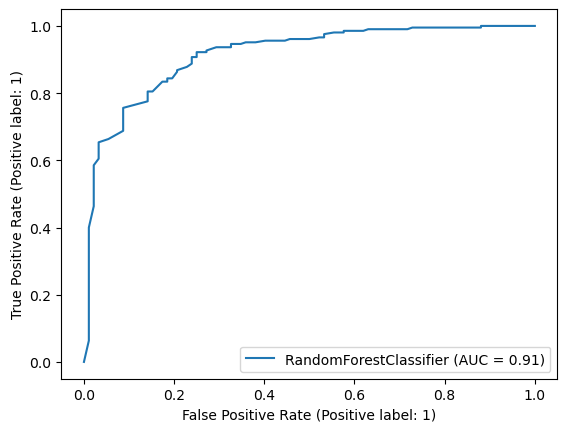

In [100]:
from sklearn.metrics import RocCurveDisplay
rf_morgan2_disp = RocCurveDisplay.from_estimator(rf_morgan2, X_test, y_test)


## 3.2. Xây dựng mô hình XGBoost với Morgan 2

In [72]:
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=100, objective='binary:logistic')
bst.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
bst_y_pred = bst.predict(X_test)
print("Dự đoán vs thực tế")
print(np.concatenate((bst_y_pred.reshape(len(bst_y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

<b>Mean average precision</b> <br>
Mean average precision (MAP) for a set of queries is the mean of the average precision scores for each query.



<b>TODO: CẦN KIỂM TRA LẠI PHẦN NÀY LÀM GÌ</b>

In [94]:
import xgboost as xgb
from xgboost import cv
data_dmatrix = xgb.DMatrix(data=train_test_x,label=train_test_y)
params = {'max_depth':2, 'eta':1, 'objective':'binary:logistic'}
num_round = 3
res = xgb.cv(params, data_dmatrix, num_round, nfold=10,
       metrics={'map'}, seed=0,
       callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])
print(res)

[0]	train-map:0.80717+0.00779	test-map:0.83025+0.06262
[1]	train-map:0.82555+0.00982	test-map:0.83017+0.05405
[2]	train-map:0.85658+0.02188	test-map:0.84112+0.05043
   train-map-mean  train-map-std  test-map-mean  test-map-std
0        0.807168       0.007791       0.830249      0.062621
1        0.825550       0.009819       0.830165      0.054048
2        0.856578       0.021878       0.841125      0.050425


In [86]:
from sklearn.metrics import confusion_matrix, accuracy_score
bst_cm = confusion_matrix(y_test, bst_y_pred)
print(cm)
bst_morgan2_accuracy = accuracy_score(y_test, bst_y_pred)
print("Độ chính xác AC: " + str(bst_morgan2_accuracy))
print("So sánh với độ chính xác của họ là 0.864 thì độ lệnh là: " + str((0.864-bst_morgan2_accuracy)*100))

[[ 59  33]
 [ 10 195]]
Độ chính xác AC: 0.8484848484848485
So sánh với độ chính xác của họ là 0.864 thì độ lệnh là: 1.5515151515151482


In [103]:
roc_auc_score(y_test, bst_y_pred)

0.8033669141039235

So sánh với cách vẽ trong link này
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html

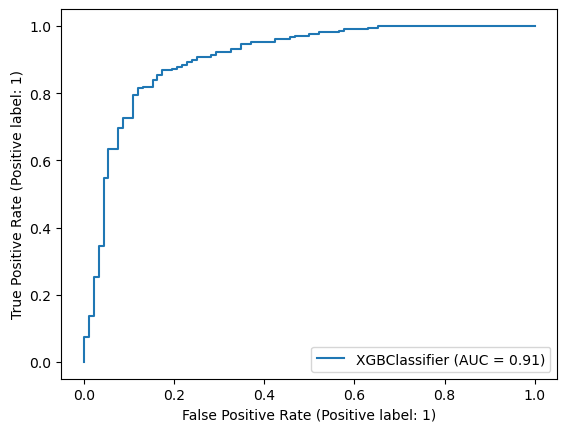

In [107]:
xgboost_disp = RocCurveDisplay.from_estimator(bst, X_test, y_test)